## Catchment Hydrology, MSc course
### Streamflow analysis using baseflow seperation and flow duration curves
### Wouter R. Berghuijs (w.r.berghuijs@vu.nl)

*These materials are based on: https://www.lawrencesekaluvu.com/hydrologic-models-tools/hydrologic-tools/usgs-streamflow*

This code can download streamflow data from the United States Geological Survey. The purpose of this notebook is to familiarize you with what a timeseries of baseflow may look like compared to total streamflow, and how this baseflow (and streamflow) may differ across different catchments. It will also show the flow duration curves for these catchments. 

The baseflow filter in this notebook is based on Eckhardt (2004) and is defined as:

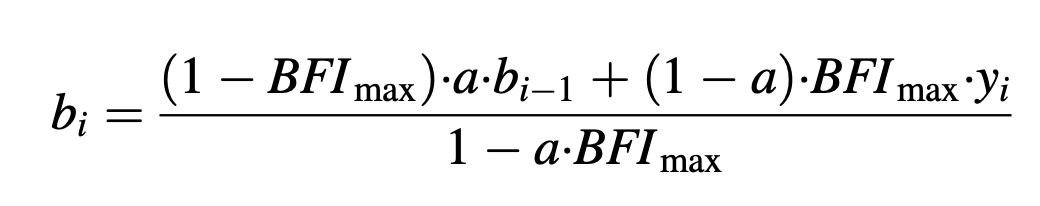

where $b_i$ equals the baseflow rate, $y_i$ is the streamflow rate, and $a$ and $BFI_{max} $  are parameters that need to be (arbitrarily) defined by the user. 

You can run the code for the example catchment given, but once that works you can change the catchment and timeperiod according to your own preferences. See the lines of code right below  

#### Lines of code to change the catchment and the time period to be analyzed

In [26]:
# Pick the gauge and time period of interest.
# You can select a streamflow gauge using:
# https://maps.waterdata.usgs.gov/mapper/index.html
# Note that catchemnts may having missing data

station_id = '07374000'   #change this into another catchment numbers available via the provided website
start_date = '2015-10-01' #set to start date
end_date   = '2020-10-19' #set to end date

#### From hereon no changes need to be made to the code and you can just run it

In [27]:
#Import required packages
import hydrofunctions as hf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib inline

# A function that downloads the daily streamflow data from the USGS database

def streamflow_raw (station_id,start_date, end_date):
    # Extract streamflow from a gauge
    flow_extract = hf.NWIS(str(station_id), 'dv', start_date, end_date, parameterCd='00060')
    # Convert the data object to a data frame
    raw_flow = flow_extract.get_data().df().reset_index()
    # Add names to the data frame
    raw_flow.columns = ['Date', 'Flow (cfs)', 'Code']
    # set date as index
    raw_flow.index = pd.to_datetime(raw_flow.Date)
    # Exclude negative flow values if they exist and replace any negative values with nan if any
    raw_flow.loc[raw_flow['Flow (cfs)']<0,'Flow (cfs)'] = np.nan
    # Make sure that the dates are consistent
    raw_flow_daily = raw_flow [['Flow (cfs)', 'Code']].resample('D').asfreq()
    return (raw_flow_daily.round(2))

# Extract streamflow data using streamflow_raw function
raw_flow = streamflow_raw (station_id,start_date, end_date)

# A baseflow seperation filer based on Eckhardt (2004)

"""
A function Eckhardt that separates streamflow into baseflow and stormflow. 
The recursive digital filter for baseflow separation developed Based on Eckhardt (2004)
Inputs:
Qt: Time series of streamflow measurements
alpha : filter parameter
BFI : maximum baseflow index
re : number of times to run filter
"""

def Eckhardt(Qt,alpha, BFI, re):
    bflow = []
    # Check if bflow is empty - useful in handling multiple filtering
    if len(bflow) > 0:
        Qt = np.array(bflow)
    else:
        Qt = np.array(Qt)
    # Create an array of zeros - used to collect basefloe values
    f = np.zeros(len(Qt))
    
    # Initialize baseflow at time, t = 0 
    f[0] = Qt[0]
    # Filter out baseflow from streamflow
    for t in np.arange(1,len(Qt)):
        # algorithm
        f[t] = ((1 - BFI) * alpha * f[t-1] + (1 - alpha) * BFI * Qt[t]) / (1 - alpha * BFI)
        if f[t] > Qt[t]:
            f[t] = Qt[t]
            
    # Adds the baseflow to self variables so it can be called recursively
    bflow = f
    # calls method again if multiple passes are specified
    if re > 1:
        bflow = Eckhardt(Qt,bflow,alpha=alpha, BFI=BFI, re=re-1)
    
    return (bflow)

# Parameters for Eckhardt function
q = raw_flow['Flow (cfs)']
alpha = 0.975
re = 1
bfi = 0.7

# Running the Eckhardt algorithm
baseflow = Eckhardt(q,alpha, bfi, re)

# Add base flow to the streamflow data frame
raw_flow['baseflow'] = baseflow
# Compute runoff
raw_flow['runoff'] = q-baseflow

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07374000&parameterCd=00060&startDT=2015-10-01&endDT=2020-10-19


/Users/wbs211/opt/anaconda3/lib/python3.9/site-packages/hydrofunctions/station.py:311: FutureWarning: It is no longer necessary to call .get_data() to request data.
  warnings.warn(


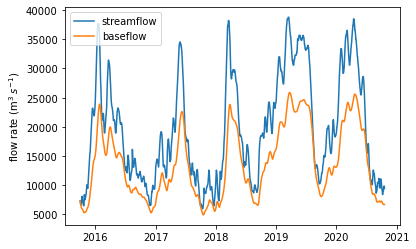

In [28]:
## Plot the Hydrograph
plt.plot(0.0283168466*raw_flow['Flow (cfs)'])
plt.plot(0.0283168466*raw_flow['baseflow'])
plt.ylabel('flow rate (m$^3$ $s^{-1}$)')
plt.legend(['streamflow','baseflow'])

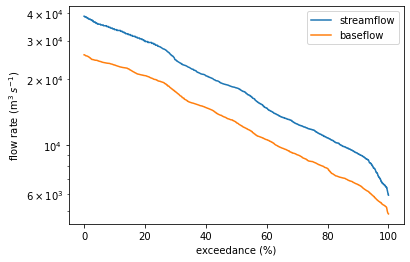

In [31]:
## Plot the Flow Duration Curve
Q_FDC = raw_flow.sort_values(by=['Flow (cfs)'])
Q_FDC1 = np.array(Q_FDC['Flow (cfs)'])
Q_FDC = raw_flow.sort_values(by=['baseflow'])
Q_FDC2 = np.array(Q_FDC['baseflow'])
x = np.linspace(100,0,len(Q_FDC2))
plt.plot(x,0.0283168466*Q_FDC1)
plt.plot(x,0.0283168466*Q_FDC2)
plt.yscale('log')
plt.ylabel('flow rate (m$^3$ $s^{-1}$)')
plt.xlabel('exceedance (%)')
plt.legend(['streamflow','baseflow'])

**Question** Pick a few catchments across different regions of the United States. What broad differences do you see in the shape of the hydrograph, the importance of baseflow, and the shape of the flow duration curve?